In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.metrics import roc_auc_score as auc
import time
import seaborn as sns

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

#%% load data and remove constant and duplicate columns  (taken from a kaggle script)

trainDataFrame = pd.read_csv('./data/train.csv')

# remove constant columns
colsToRemove = []
for col in trainDataFrame.columns:
    if trainDataFrame[col].std() == 0:
        colsToRemove.append(col)

trainDataFrame.drop(colsToRemove, axis=1, inplace=True)

# remove duplicate columns
colsToRemove = []
columns = trainDataFrame.columns
for i in range(len(columns)-1):
    v = trainDataFrame[columns[i]].values
    for j in range(i+1,len(columns)):
        if np.array_equal(v,trainDataFrame[columns[j]].values):
            colsToRemove.append(columns[j])

trainDataFrame.drop(colsToRemove, axis=1, inplace=True)

trainLabels = trainDataFrame['TARGET']
trainFeatures = trainDataFrame.drop(['ID','TARGET'], axis=1)


#%% look at single feature performance

X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(trainFeatures, trainLabels, 
                                                                       test_size=0.5, random_state=1)
# verySimpleLearner = ensemble.GradientBoostingClassifier(n_estimators=20, max_features=1, max_depth=3, 
#                                                         min_samples_leaf=100, learning_rate=0.1, 
#                                                         subsample=0.65, loss='deviance', random_state=1)

verySimpleLearner = LogisticRegression()

startTime = time.time()
singleFeatureTable = pd.DataFrame(index=range(len(X_train.columns)), columns=['feature','AUC'])
for k,feature in enumerate(X_train.columns):
    trainInputFeature = X_train[feature].values.reshape(-1,1)
    validInputFeature = X_valid[feature].values.reshape(-1,1)
    verySimpleLearner.fit(trainInputFeature, y_train)
    
    validAUC = auc(y_valid, verySimpleLearner.predict_proba(validInputFeature)[:,1])
    singleFeatureTable.ix[k,'feature'] = feature
    singleFeatureTable.ix[k,'AUC'] = validAUC
        
print("finished evaluating single features. took %.2f minutes" %((time.time()-startTime)/60))

finished evaluating single features. took 0.19 minutes


In [3]:
#%% sort according to AUC and present the table
singleFeatureTable = singleFeatureTable.sort_values(by='AUC', axis=0, ascending=False).reset_index(drop=True)

singleFeatureTable.ix[:15,:]

,feature,AUC
0,var15,0.699413
1,saldo_var30,0.6852
2,num_meses_var5_ult3,0.682985
3,num_var30,0.671324
4,saldo_var42,0.668217
5,saldo_var5,0.667349
6,saldo_medio_var5_hace2,0.666227
7,saldo_medio_var5_ult3,0.663955
8,ind_var30,0.663864
9,saldo_medio_var5_ult1,0.663135


(min,max) AUC = (0.3184,0.7783). took 3.1 minutes


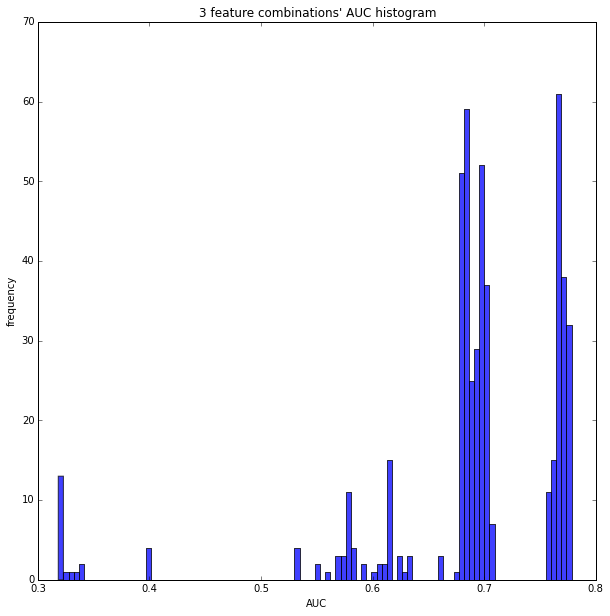

In [6]:
#%% find interesting fivewise combinations

numFeaturesInCombination = 5
numCombinations = 500
numBestSingleFeaturesToSelectFrom = 10

X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(trainFeatures, trainLabels, 
                                                                       test_size=0.5, random_state=1)
# weakLearner = ensemble.GradientBoostingClassifier(n_estimators=30, max_features=2, max_depth=3, 
#                                                   min_samples_leaf=100,learning_rate=0.1, 
#                                                   subsample=0.65, loss='deviance', random_state=1)

weakLearner = LogisticRegression()

featuresToUse = singleFeatureTable.ix[0:numBestSingleFeaturesToSelectFrom-1,'feature']
featureColumnNames = ['feature'+str(x+1) for x in range(numFeaturesInCombination)]
featureCombinationsTable = pd.DataFrame(index=range(numCombinations), columns=featureColumnNames + ['combinedAUC'])

# for numCombinations iterations 
startTime = time.time()
for combination in range(numCombinations):
    # generate random feature combination
    randomSelectionOfFeatures = sorted(np.random.choice(len(featuresToUse), numFeaturesInCombination, replace=False))

    # store the feature names
    combinationFeatureNames = [featuresToUse[x] for x in randomSelectionOfFeatures]
    for i in range(len(randomSelectionOfFeatures)):
        featureCombinationsTable.ix[combination,featureColumnNames[i]] = combinationFeatureNames[i]

    # build features matrix to get the combination AUC
    trainInputFeatures = X_train.ix[:,combinationFeatureNames]
    validInputFeatures = X_valid.ix[:,combinationFeatureNames]
    # train learner
    weakLearner.fit(trainInputFeatures, y_train)
    # store AUC results
    validAUC = auc(y_valid, weakLearner.predict_proba(validInputFeatures)[:,1])        
    featureCombinationsTable.ix[combination,'combinedAUC'] = validAUC

validAUC = np.array(featureCombinationsTable.ix[:,'combinedAUC'])
print("(min,max) AUC = (%.4f,%.4f). took %.1f minutes" % (validAUC.min(),validAUC.max(), (time.time()-startTime)/60))

# show the histogram of the feature combinations performance 
plt.figure(); plt.hist(validAUC, 100, facecolor='blue', alpha=0.75)
plt.xlabel('AUC'); plt.ylabel('frequency'); plt.title("3 feature combinations' AUC histogram"); plt.show()

In [7]:
#%% sort according to combination AUC and look at the table

featureCombinationsTable = featureCombinationsTable.sort_values(by='combinedAUC', axis=0, ascending=False).reset_index(drop=True)
featureCombinationsTable.ix[:20,:]

,feature1,feature2,feature3,feature4,feature5,combinedAUC
0,var15,saldo_var30,num_meses_var5_ult3,saldo_medio_var5_hace2,ind_var30,0.778333
1,var15,saldo_var30,num_meses_var5_ult3,num_var30,saldo_medio_var5_hace2,0.777845
2,var15,saldo_var30,num_meses_var5_ult3,saldo_var42,saldo_medio_var5_ult3,0.777178
3,var15,saldo_var30,num_var30,saldo_var42,saldo_medio_var5_ult3,0.776738
4,var15,saldo_var30,num_var30,saldo_var42,saldo_medio_var5_ult3,0.776738
5,var15,saldo_var30,saldo_var5,saldo_medio_var5_hace2,ind_var30,0.776636
6,var15,saldo_var30,saldo_var5,saldo_medio_var5_hace2,ind_var30,0.776636
7,var15,saldo_var30,saldo_var5,saldo_medio_var5_hace2,ind_var30,0.776636
8,var15,saldo_var30,saldo_var5,saldo_medio_var5_hace2,ind_var30,0.776636
9,var15,saldo_var30,saldo_medio_var5_hace2,saldo_medio_var5_ult3,ind_var30,0.776238


In [8]:
trainDataFrame['var15'].describe()

count    76020.000000
mean        33.212865
std         12.956486
min          5.000000
25%         23.000000
50%         28.000000
75%         40.000000
max        105.000000
Name: var15, dtype: float64

In [9]:
trainDataFrame['saldo_var30'].describe()

count      76020.000000
mean       13679.673658
std        63014.078142
min        -4942.260000
25%            0.000000
50%            3.000000
75%          235.995000
max      3458077.320000
Name: saldo_var30, dtype: float64

In [10]:
trainDataFrame['num_meses_var5_ult3'].describe()

count    76020.000000
mean         1.979979
std          1.298924
min          0.000000
25%          0.000000
50%          3.000000
75%          3.000000
max          3.000000
Name: num_meses_var5_ult3, dtype: float64

In [11]:
trainDataFrame['num_var30'].describe()

count    76020.000000
mean         2.382873
std          1.642787
min          0.000000
25%          0.000000
50%          3.000000
75%          3.000000
max         33.000000
Name: num_var30, dtype: float64

In [12]:
trainDataFrame['saldo_var42'].describe()

count      76020.000000
mean        7191.725395
std        49145.313879
min        -4942.260000
25%            0.000000
50%            3.000000
75%          120.000000
max      3008077.320000
Name: saldo_var42, dtype: float64

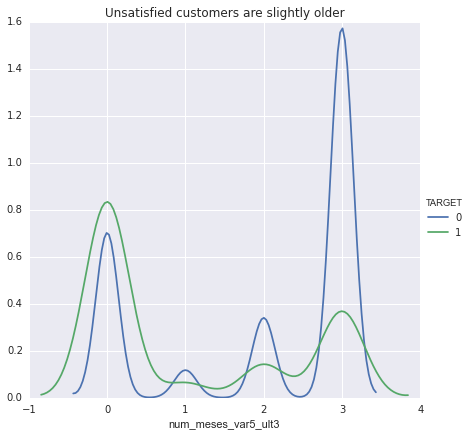

In [26]:
sns.FacetGrid(trainDataFrame, hue="TARGET", size=6) \
   .map(sns.kdeplot, "num_meses_var5_ult3") \
   .add_legend()
plt.title('Unsatisfied customers are slightly older')
plt.show()